In [ ]:
!pip3 install 'imageio==2.4.1'
!pip3 install matplotlib
!pip3 install tf-agents[reverb]
# !pip3 install tf-agents
# !pip3 install reverb
!pip3 install pybullet --upgrade
!pip3 install imgaug==0.2.6
!pip3 install folium==0.2.1

In [ ]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import os
import reverb
import tempfile
import PIL.Image

import tensorflow as tf

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.environments import suite_pybullet
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils

tempdir = tempfile.gettempdir()

<h3>Hyperparameters</h3>

In [ ]:
num_iterations = 100000
actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

# param for collect
initial_collect_steps = 10000 
collect_steps_per_iteration = 1
replay_buffer_capacity = 1000000

# param for train
train_steps_per_iteration = 1
batch_size = 256
actor_learning_rate = 3e-3
critic_learning_rate = 3e-4
alpha_learning_rate = 3e-3
# lr = np.array([1e-3,5e-5,3e-4,3e-3,1e-5]);
# lr = random.choices(lr, k=1)[0];
# critic_learning_rate = lr
# actor_learning_rate = lr
# alpha_learning_rate = lr
gamma=0.99
# reward_scale_factor=0.1
reward_scale_factor = 1.0

# param for eval
num_eval_episodes = 30
eval_interval = 10000

# param for target update
target_update_tau = 0.005
target_update_period = 1 

# param for summary and logging
log_interval = 5000 
policy_save_interval = 5000 

<h3>Environment</h3>

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


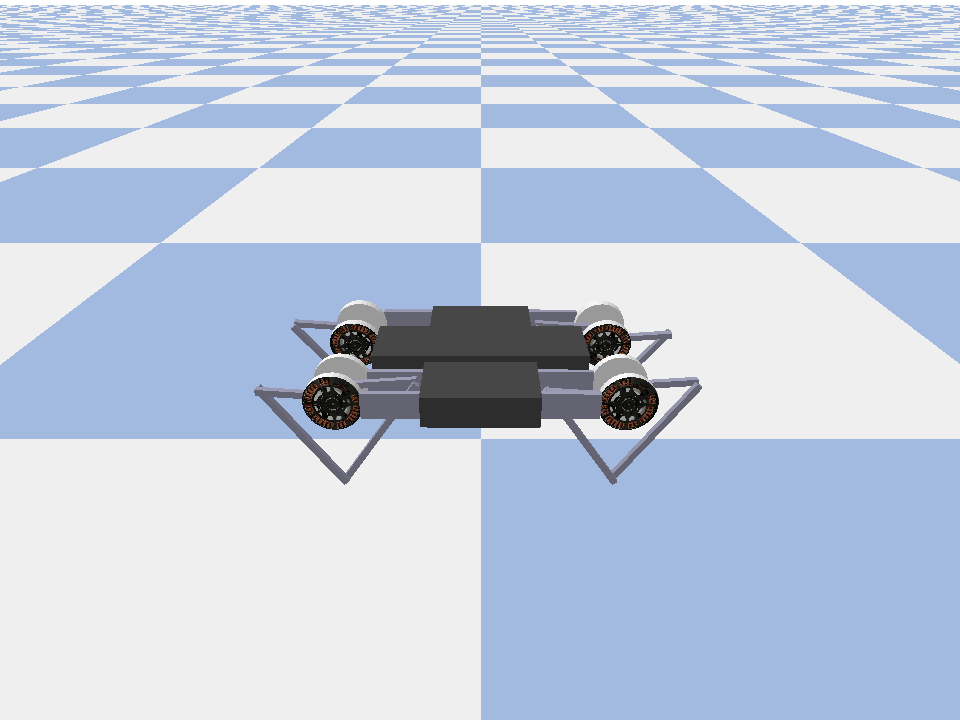

In [ ]:
env_name = "MinitaurBulletEnv-v0"
env = suite_pybullet.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(28,), dtype=dtype('float32'), name='observation', minimum=[  -3.1515927   -3.1515927   -3.1515927   -3.1515927   -3.1515927
   -3.1515927   -3.1515927   -3.1515927 -167.72488   -167.72488
 -167.72488   -167.72488   -167.72488   -167.72488   -167.72488
 -167.72488     -5.71        -5.71        -5.71        -5.71
   -5.71        -5.71        -5.71        -5.71        -1.01
   -1.01        -1.01        -1.01     ], maximum=[  3.1515927   3.1515927   3.1515927   3.1515927   3.1515927   3.1515927
   3.1515927   3.1515927 167.72488   167.72488   167.72488   167.72488
 167.72488   167.72488   167.72488   167.72488     5.71        5.71
   5.71        5.71        5.71        5.71        5.71        5.71
   1.01        1.01        1.01        1.01     ])
Action Spec:
BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0)


In [ ]:
collect_env = suite_pybullet.load(env_name)
eval_env = suite_pybullet.load(env_name)

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data
urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# collect_env.reset()
# PIL.Image.fromarray(collect_env.render())

In [ ]:
# eval_env.reset()
# PIL.Image.fromarray(eval_env.render())

<h3>Distribution Strategy</h3>

<t>Use CUDA</t>

In [ ]:
use_gpu = True

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


<h3>Agent</h3>

In [ ]:
observation_spec, action_spec, time_step_spec = (
      spec_utils.get_tensor_specs(collect_env))

with strategy.scope():
  # Value Network
  critic_net = critic_network.CriticNetwork(
        (observation_spec, action_spec),
        observation_fc_layer_params = None,
        action_fc_layer_params = None,
        joint_fc_layer_params = critic_joint_fc_layer_params,
        kernel_initializer = 'glorot_uniform',
        last_kernel_initializer = 'glorot_uniform')
  
  # Policy Network
  actor_net = actor_distribution_network.ActorDistributionNetwork(
      observation_spec,action_spec,
      fc_layer_params = actor_fc_layer_params,
      continuous_projection_net = (
          tanh_normal_projection_network.TanhNormalProjectionNetwork))

  train_step = train_utils.create_train_step()

  tf_agent = sac_agent.SacAgent(
      time_step_spec,
      action_spec,
      actor_network = actor_net,
      critic_network = critic_net,
      actor_optimizer = tf.compat.v1.train.AdamOptimizer(
          learning_rate=actor_learning_rate),
      critic_optimizer = tf.compat.v1.train.AdamOptimizer(
          learning_rate = critic_learning_rate),
      alpha_optimizer = tf.compat.v1.train.AdamOptimizer(
          learning_rate = alpha_learning_rate),
      target_update_tau = target_update_tau,
      target_update_period = target_update_period,
      td_errors_loss_fn = tf.math.squared_difference,
      gamma = gamma,
      reward_scale_factor = reward_scale_factor,
      train_step_counter = train_step)

  tf_agent.initialize()

<h3>Replay Buffer</h3>

In [ ]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

In [ ]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length = 2,
    table_name = table_name,
    local_server = reverb_server)

In [ ]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps = 2).prefetch(50)
experience_dataset_fn = lambda: dataset

<h3>Policies</h3>

In [ ]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [ ]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

In [ ]:
random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

<h3>Actors</h3>

In [ ]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

In [ ]:
initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  train_step,
  steps_per_run = initial_collect_steps,
  observers = [rb_observer])
initial_collect_actor.run()

In [ ]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  train_step,
  steps_per_run = 1,
  metrics = actor.collect_metrics(10),
  summary_dir = os.path.join(tempdir, learner.TRAIN_DIR),
  observers = [rb_observer, env_step_metric])

In [ ]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

<h3>Learners</h3>

In [ ]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


Instructions for updating:
rename to distribute_datasets_from_function


Instructions for updating:
rename to distribute_datasets_from_function


<h3>Metrics and Evaluation</h3>

In [ ]:
def get_eval_metrics():
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  return results

metrics = get_eval_metrics()

In [ ]:
def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = -0.171751, AverageEpisodeLength = 64.400002


<h3>Training the agent</h3>

In [ ]:
## @test {"skip": true}
try:
  %%time
except:
  pass

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
  # Training.
  collect_actor.run()
  loss_info = agent_learner.run(iterations=1)

  # Evaluating.
  step = agent_learner.train_step_numpy

  if eval_interval and step % eval_interval == 0:
    metrics = get_eval_metrics()
    log_eval_metrics(step, metrics)
    returns.append(metrics["AverageReturn"])

  if log_interval and step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

rb_observer.close()
reverb_server.stop()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
step = 5000: loss = -1.200564980506897
step = 10000: AverageReturn = -0.478569, AverageEpisodeLength = 277.133331
step = 10000: loss = -1.7517032623291016
step = 15000: loss = 6.612117767333984
step = 20000: AverageReturn = -0.743884, AverageEpisodeLength = 305.833344
step = 20000: loss = -8.718352317810059
step = 25000: loss = -0.781425952911377
step = 30000: AverageReturn = 0.652807, AverageEpisodeLength = 420.233337
step = 30000: loss = 9.912888526916504
step = 35000: loss = -2.32773494720459
step = 40000: AverageReturn = 3.238114, AverageEpisodeLength = 745.000000
step = 40000: loss = 0.07358738780021667
step = 45000: loss = 0.36384981870651245
step = 50000: AverageReturn = 0.898586, AverageEpisodeLength = 263.299988
step = 50000: loss = -2.5170700550079346
step = 55000: loss = 2.1797232627868652
step = 60000: AverageReturn = 0.673038, AverageEpisodeLength = 136.633331
step = 60000: loss = -1.0464329719543457
step 

<h3>Visualization</h3>

<t>Plots</t>

(-0.9629399299621582, 3.8562833786010744)

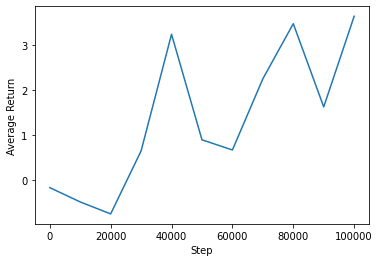

In [ ]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

<t>Videos</t>

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
num_episodes = 1
video_filename = 'sac_minitaur.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_env.render())
    while not time_step.is_last():
      action_step = eval_actor.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_env.render())

embed_mp4(video_filename)